In [1]:
from util.sparkhandler import SparkHandler
from util.dataproctools import get_extracted_wet, save_rdd, load_rdd
from util.dataproctools import extracted_wet_to_df
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
import optuna

In [2]:
handler = SparkHandler(available_cores=4) # look at the parameters for SparkHandler to increase max memory
ss = handler.get_spark_session()
sc = handler.get_spark_context()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/10 19:35:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/10 19:35:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/12/10 19:35:39 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/12/10 19:35:39 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
raw_data = get_extracted_wet(spark_context=sc, approx_sample_size=20000, wet_paths_file="data/wet.paths")
save_rdd(raw_data, "saved_intermediates/rawStrRDD", overwrite=True)

In [4]:
# raw_data = load_rdd(spark_context=sc, path_to_load="../saved_intermediates/rawStrRDD")

In [5]:
df = extracted_wet_to_df(spark_session=ss, extracted_wet_rdd=raw_data)
filtered = df.filter(((df.tld == '.gov') | (df.tld == '.edu')) & (df.languages == 'eng'))
filtered.write.mode("overwrite").format("json").save("saved_intermediates/filtered_dataframe")

In [6]:
loaded_df = ss.read.json("saved_intermediates/filtered_dataframe")

In [7]:
loaded_df.head()

Row(date='2025-11-15T20:46:04Z', languages='eng', raw_content='\r\nVirginia Tech Dendrology Fact Sheet\nVirginia Tech Dendrology\nCalifornia red fir Pinaceae Abies magnifica A. Murray bis symbol: ABMA\nLeaf: Flattened needles, about 1 inch long, linear, and 4-angled in cross-section with a ridge on top along the midrib; bluish white bloom on all surfaces; base curves, making the needle resemble a hockey stick; tips mostly rounded but may be pointed on cone-bearing branches; spirally arranged but usually upswept.\nFlower: Species is monoecious; male cones purple to dark red and borne on undersides of branches; female cones are reddish-brown and borne upright near the top of the crown.\nFruit: Cones are 6 to 9 inches long, cylindrical, and borne upright on the twig; cone scales are deciduous, falling from the cone as seeds ripen; purple when mature; bracts are shorter than the scales (as opposed to noble fir). Shasta red fir (a hybrid) has bracts longer than cone scales.\nTwig: Stiff, re

In [8]:
tuning_sample = loaded_df.sample(0.2)
train, val, test = tuning_sample.randomSplit([0.7, 0.2, 0.1], seed=1237)

In [9]:
def objective(trial: optuna.trial.Trial):

    minTokenLength = trial.suggest_int("min word len", 1, 3)
    k = 12
    learningDecay = trial.suggest_float("lr decay", 0.5, 1.0)
    learningOffset = trial.suggest_float("offset", 0, 10)
    maxItr = trial.suggest_int("intrs", 10, 100)
    subsamplingRate = trial.suggest_float("subsampling rate", 0, 1)

    # 1) Tokenize text into tokens
    tokenizer = RegexTokenizer(minTokenLength=minTokenLength, gaps=False, pattern=r"\b[a-zA-Z]+[\d]*(?:[-'][a-zA-Z]+[\d]*)*\b", inputCol="raw_content", outputCol="tokenized")

    # 2) Remove stopwords
    remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered")

    # 3) Convert tokens to term-frequency vectors
    cv = CountVectorizer(
        inputCol="filtered",
        outputCol="features",
        vocabSize=5000,
        minDF=1    # keep terms that appear in at least 1 document
    )

    # 4) LDA model (k = number of topics)
    lda = LDA(
        k=k,
        learningDecay=learningDecay,
        learningOffset=learningOffset,
        maxIter=maxItr,
        subsamplingRate=subsamplingRate,
        featuresCol="features"
    )

    # 5) Build pipeline
    pipeline = Pipeline(stages=[tokenizer, remover, cv, lda])
    model = pipeline.fit(train)
    valed = model.transform(val)
    perplexity = model.stages[-1].logPerplexity(valed)
    log_likelyhood = model.stages[-1].logLikelihood(valed)
    return perplexity, log_likelyhood

In [10]:
study = optuna.create_study(directions=["minimize", "maximize"])

[I 2025-12-10 19:36:02,419] A new study created in memory with name: no-name-d7f5cddd-d4fa-4e69-8fe8-0872f3a0b18a


In [11]:
study.optimize(objective, n_trials=10, timeout=300, n_jobs=8)

25/12/10 19:36:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
[I 2025-12-10 19:36:10,843] Trial 7 finished with values: [15.104967071939587, -70328.72668695071] and parameters: {'min word len': 3, 'lr decay': 0.9869414103075651, 'offset': 3.700848697532182, 'intrs': 16, 'subsampling rate': 0.26881886467384963}.
[I 2025-12-10 19:36:11,771] Trial 1 finished with values: [10.847279638872404, -50754.421430283975] and parameters: {'min word len': 2, 'lr decay': 0.737041063389807, 'offset': 3.80938750697955, 'intrs': 26, 'subsampling rate': 0.30165787446632064}.
[I 2025-12-10 19:36:12,080] Trial 3 finished with values: [10.817695190845802, -50615.99579796751] and parameters: {'min word len': 2, 'lr decay': 0.6511609350796939, 'offset': 5.842800649146711, 'intrs': 26, 'subsampling rate': 0.9181345854708888}.
[I 2025-12-10 19:36:12,515] Trial 2 finished with values: [17.375339344091856, -82185.35509755448] and parameters: {'min word len': 1, 'lr dec

In [12]:
best_params = study.best_trials[-1].params
best_params

{'min word len': 2,
 'lr decay': 0.6511609350796939,
 'offset': 5.842800649146711,
 'intrs': 26,
 'subsampling rate': 0.9181345854708888}

In [13]:
#def objective(trial: optuna.trial.Trial):

minTokenLength = best_params['min word len']
k = 12
learningDecay = best_params['lr decay']
learningOffset = best_params['offset']
maxItr = best_params['intrs']
subsamplingRate = best_params['subsampling rate']

# 1) Tokenize text into tokens
tokenizer = RegexTokenizer(minTokenLength=minTokenLength, gaps=False, pattern=r"\b[a-zA-Z]+[\d]*(?:[-'][a-zA-Z]+[\d]*)*\b", inputCol="raw_content", outputCol="tokenized")

# 2) Remove stopwords
remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered")

# 3) Convert tokens to term-frequency vectors
cv = CountVectorizer(
    inputCol="filtered",
    outputCol="features",
    vocabSize=5000,
    minDF=1    # keep terms that appear in at least 1 document
)

# 4) LDA model (k = number of topics)
lda = LDA(
    k=k,
    learningDecay=learningDecay,
    learningOffset=learningOffset,
    maxIter=maxItr,
    subsamplingRate=subsamplingRate,
    featuresCol="features"
)

# 5) Build pipeline
pipeline = Pipeline(stages=[tokenizer, remover, cv, lda])
model = pipeline.fit(loaded_df)
transformed = model.transform(loaded_df)

In [15]:
# Extract the CV and LDA sub-models
cv_model = model.stages[2]
lda_model = model.stages[3]

vocab = cv_model.vocabulary

In [17]:
from util.updatedVIZ import visualize_topics

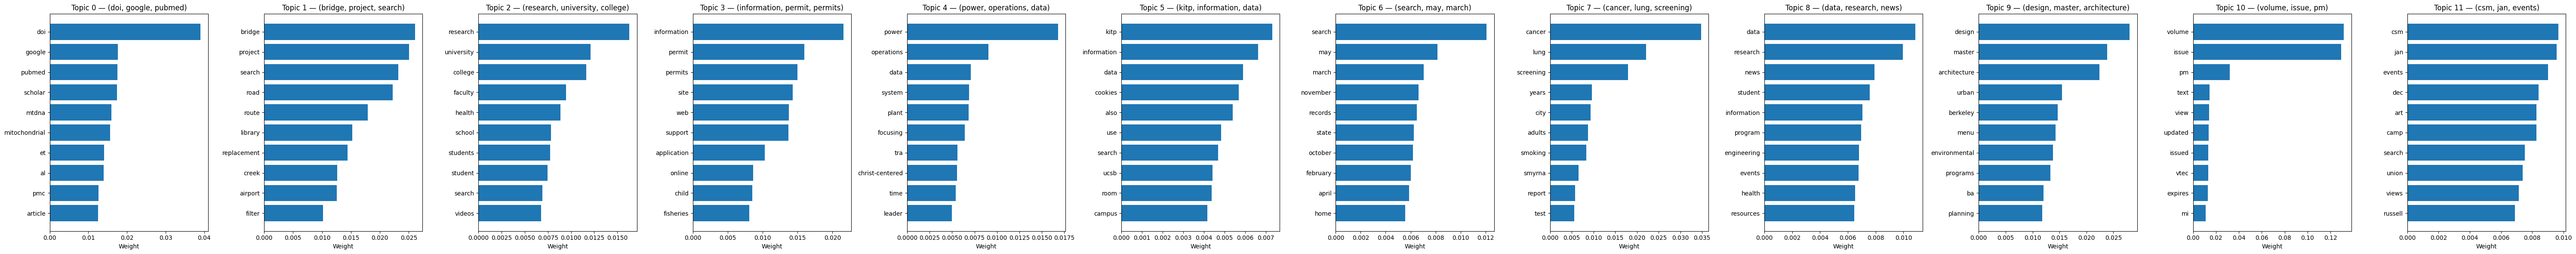

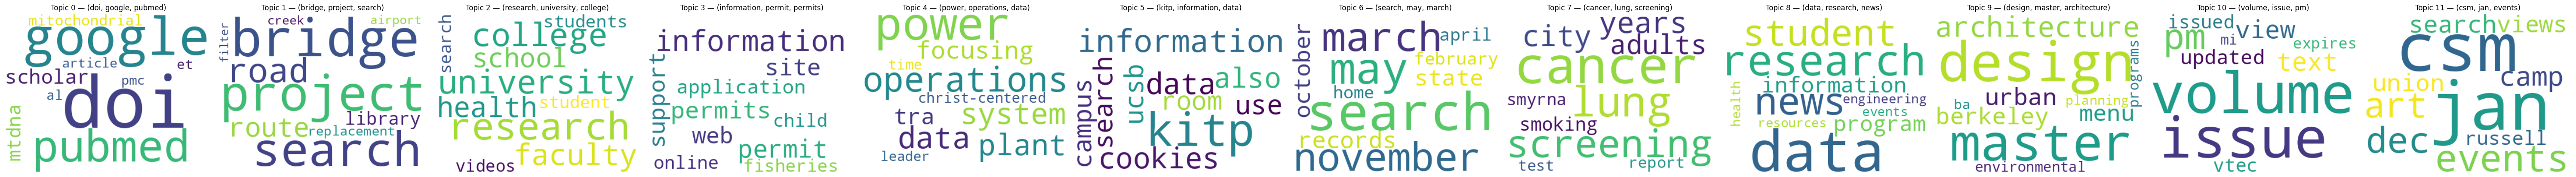

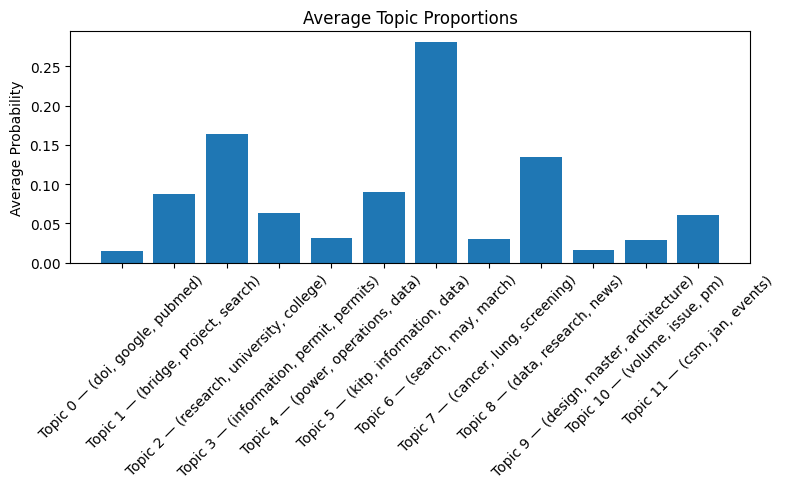

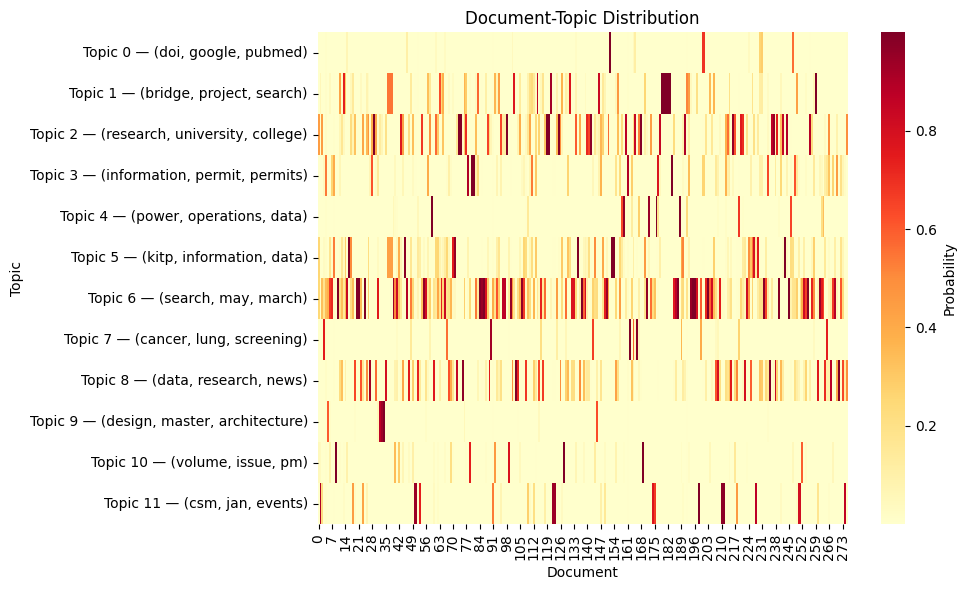

In [18]:
visualize_topics(lda_model, vocab, transformed, num_words=10)